In [1]:
'''Updated Experimental Framework: ICL-Based Sentiment Classification with Data Poisoning Evaluation
The experimental workflow,  initiates with the collection of tweets using the Twitter API, focusing on public 
discourse surrounding health crises like HMPV. Tweets were filtered by relevant hashtags and keywords to ensure
topical relevance.
Following data acquisition, a comprehensive preprocessing pipeline was applied. This included text normalization 
steps such as lowercasing, removal of punctuation, hashtags, mentions, URLs, stopwords, and numeric words. Tokenization
was used to segment the text, followed by stemming and lemmatization for normalization and linguistic consistency.
Unlike traditional lexicon-based methods such as TextBlob, this study utilizes Large Language Models (LLMs) for
sentiment classification via In-Context Learning (ICL). In this setup, instead of training or fine-tuning models, 
a fixed pre-trained LLM is queried by automatically generated few-shot examples provided as input context. 
For each target tweet, a dynamic ICL input is constructed using a small number of labeled tweets (e.g., 3–5 examples),
formatted as plain text within the context window. The model then predicts the sentiment of the target tweet (Positive,
Negative, or Neutral) based on these in-context examples. The entire prompt construction and querying process is fully
automated via script, ensuring scalability and reproducibility without manual prompt engineering.

To investigate the security vulnerabilities of ICL, we introduce a data poisoning component based on the 
ICLPoison framework. In this setting, we construct poisoned ICL contexts by injecting mislabeled examples into
the in-context input. 
These discrete perturbations are designed to mislead the LLM and degrade its classification accuracy'''

'''Data preprocessing

Labeled/unlabeled split

ICL prediction (clean & poisoned)

Adversarial perturbation logging

Spectral Defense'''


# First cell - Import libraries and setup
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import string
import nltk
import re
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import plotly.express as px

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

# Load the Excel data
hmpv_df = pd.read_excel('/kaggle/input/newhmpv/hmpv_tweet.xlsx')

# Check the data
hmpv_df.head()
print("HMPV Dataset Shape:", hmpv_df.shape)

HMPV Dataset Shape: (10117, 1)


In [3]:
# Get the data from row 5 (remember indexing starts at 0)
specific_row = hmpv_df.iloc[103]

# Display the row
print(specific_row)


tweet    @HealthDeptBD: "Alert: HMPV detected in Bangla...
Name: 103, dtype: object


In [4]:
# Third cell - Part 1: Check column names
print("hmpv DataFrame Columns:")
print(hmpv_df.columns.tolist())

hmpv DataFrame Columns:
['tweet']


In [5]:
print('Rows and columns in training dataset hmpv : ',hmpv_df.shape)

Rows and columns in training dataset hmpv :  (10117, 1)


In [6]:
print('Rows and columns in training dataset hmpv : ',hmpv_df.shape)

Rows and columns in training dataset hmpv :  (10117, 1)


In [7]:
import nltk
import re
import emoji
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    """Clean and preprocess text data comprehensively."""
    try:
        # Step 1: Convert to lowercase and string format
        text = str(text).lower()

        # Step 2: Normalize Unicode text
        text = unicodedata.normalize('NFKC', text).encode('ascii', 'ignore').decode('utf-8')

        # Step 3: Convert emojis to text
        text = emoji.demojize(text)

        # Step 4: Define unwanted patterns
        unwanted_patterns = [
            r'Ã³', r'±', r'à¤•', r'à¤¨', r'à¤²', r'à¤¹à¤²à¤•', r'à¤®', r'à¤•à¤ªà¤¯à¤Ÿà¤°',
            r'à¤µ', r'à¤•à¤«', r'à¤®à¤¶à¤¨', r'à¤¸', r'à¤­', r'à¤«à¤²', r'à¤¸à¤•à¤¤', r'à¤¹',
            r'à¤µà¤¯à¤°à¤¸', r'à¤¸à¤•à¤°à¤®à¤¤', r'à¤µà¤¯à¤•à¤¤', r'à¤œà¤¨à¤µà¤°',
            r'à¤¸', r'à¤°à¤¹', r'Ãª', r'Ã©', r'Ø³Ø¬Ù„Øª Ø¥ÙŠØ·Ø§Ù„ÙŠØ§ Ø§Ù„ÙŠÙˆÙ…',
            r'TÃ¼', r'bÃ¼yÃ¼tmÃ¼ÅŸ', r'Ã§Ã', r'oÃ¹', r'Ãº', r'Ã¨', r'nan', r'ÃƒÂ°ÃƒÂ¿ÃƒÂ°ÃƒÂ¿ÃƒÂ°ÃƒÂ¿'
        ]

        # Step 5: Remove unwanted patterns using regex
        for pattern in unwanted_patterns:
            text = re.sub(pattern, '', text)

        # Step 6: Remove URLs, mentions, and hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
        text = re.sub(r'@\w+', '', text)  # Mentions
        text = re.sub(r'#\w+', '', text)  # Hashtags

        # Step 7: Remove punctuations and numeric words
        text = re.sub(r'[^\w\s]', '', text)  # Punctuations
        text = re.sub(r'\w*\d\w*', '', text)  # Words with numbers

        # Step 8: Tokenize text
        tokens = word_tokenize(text)

        # Step 9: Remove stopwords
        stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'rt', 'amp', 'via', 'like', 'get', 'would', 'also', 'covid',
            'covid19', 'coronavirus', 'corona', 'virus', 'monkeypox', 'mpox',
            'pox', 'monkey'
        }
        stop_words.update(custom_stopwords)
        tokens = [word for word in tokens if word not in stop_words]

        # Step 10: Reconstruct the cleaned text
        text = ' '.join(tokens).strip()

        return text
    except Exception as e:
        print(f"Error in text preprocessing: {str(e)}")
        return text
        

print("Applying enhanced preprocessing with emoji conversion, hashtag, mention, and stopword removal...")

# List of columns to preprocess
hmpv_columns_to_process = ['tweet']

# Apply preprocessing to multiple columns
for col in hmpv_columns_to_process:
    hmpv_df[f'processed_{col}'] = hmpv_df[col].apply(preprocess_text)


print("\nSample hmpv processed text:")
print(hmpv_df[[f'processed_{col}' for col in hmpv_columns_to_process]].head())

Applying enhanced preprocessing with emoji conversion, hashtag, mention, and stopword removal...


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Sample hmpv processed text:
            processed_tweet
0    suryatweetsz see u tom
1          find amazon link
2  elon musk changed button
3          find amazon link
4                 good know


In [8]:
# Combine all processed text columns into a single column for COVID dataset
hmpv_df['processed_text_hmpv'] = hmpv_df[[f'processed_{col}' for col in hmpv_columns_to_process]].apply(lambda row: ' '.join(row.values), axis=1)

print("\nSample combined processed text for hmpv dataset:")
print(hmpv_df['processed_text_hmpv'].head())



Sample combined processed text for hmpv dataset:
0      suryatweetsz see u tom
1            find amazon link
2    elon musk changed button
3            find amazon link
4                   good know
Name: processed_text_hmpv, dtype: object


In [9]:
print('Rows and columns in training dataset hmpv : ',hmpv_df.shape)

Rows and columns in training dataset hmpv :  (10117, 3)


In [10]:
# Save the combined processed text columns to CSV files
hmpv_df[['processed_text_hmpv']].to_csv('/kaggle/working/hmpv_tweetNew.csv', index=False)

print("Combined processed text files have been saved to CSV.")

Combined processed text files have been saved to CSV.


**ICL** In-Context Learning

In [11]:
import pandas as pd

# === Step 1: Load the processed CSV file instead of Excel ===
file_path = '/kaggle/working/hmpv_tweetNew.csv'  # processed CSV file path
df = pd.read_csv(file_path)

# === Reset index to start from 1 ===
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1

# === Step 2: Create a New Column for Sentiment Labels ===
df['label'] = None  # initialize label column

# === Step 3: Define Index Lists for Each Sentiment (based on new 1-based indexing) ===
positive_indices = [238, 237, 112, 127, 130, 131, 147, 196, 256, 259, 268, 271, 272, 273, 247, 283, 284, 288, 294, 307]
negative_indices = [51, 79, 105, 106, 123, 135, 133, 142, 146, 152, 154, 159, 164, 156, 166, 173, 176, 178, 200, 232]
neutral_indices  = [27, 99, 64, 199, 2998, 3001, 3002, 3022, 3038, 3040, 3052, 3056, 3063, 3064, 3067, 3127, 3131, 10115, 10117, 9892]

# === Step 4: Filter out invalid indices (indices that exceed max index) ===
max_idx = df.index.max()

def filter_valid_indices(indices):
    invalid = [i for i in indices if i > max_idx]
    if invalid:
        print(f"Warning: These indices are invalid (out of range) and will be ignored: {invalid}")
    return [i for i in indices if i <= max_idx]

positive_indices = filter_valid_indices(positive_indices)
negative_indices = filter_valid_indices(negative_indices)
neutral_indices  = filter_valid_indices(neutral_indices)

# === Step 5: Assign Labels ===
df.loc[positive_indices, 'label'] = 'Positive'
df.loc[negative_indices, 'label'] = 'Negative'
df.loc[neutral_indices,  'label'] = 'Neutral'

# === Step 6: Check the Labeled Data ===
print("✅ Manually Labeled Tweets:")
print(df[df['label'].notnull()].head(20))  # print first 20 labeled rows

# === Step 7: Save the labeled dataset ===
df.to_csv('/kaggle/working/labeled_hmpv_tweets.csv', index=False)
print("Saved labeled dataset to /kaggle/working/labeleed_hmpv_tweets.csv")


✅ Manually Labeled Tweets:
                                   processed_text_hmpv     label
27                                    beautiful ashika   Neutral
51   nope itTMs hmpv new itTMs around usually resol...  Negative
64   quadrant future tek limited ipoa total subscri...   Neutral
79   create retrostyle gif vintage effects nostalgi...  Negative
99   chinese doctors surprised reports hmpv surge s...   Neutral
105  need panic regarding hmpv detected bangladesh ...  Negative
106  special seminar hmpv held today experts emphas...  Negative
112  researchers studying spread hmpv children five...  Positive
123  health update hmpv detected multiple countries...  Negative
127  hmpv belongs family rsv measles circulating de...  Positive
130  hmpv common children older adults protect love...  Positive
131  ever wonder respiratory viruses spread faster ...  Positive
133  hmpv infections mild manageable proper care re...  Negative
135  hmpv cases rising winter especially among chil...  Negativ

In [12]:
import pandas as pd

# === Load labeled dataset ===
df = pd.read_csv('/kaggle/working/labeled_hmpv_tweets.csv')

# === Split into labeled and unlabeled ===
df_labeled = df[df['label'].notnull()].copy()
df_unlabeled = df[df['label'].isnull()].copy()



# === Show first 10 labeled examples ===
print("🔹 Top 10 labeled tweets:")
print(df_labeled[['processed_text_hmpv', 'label']].head(10))

# === Show first 10 unlabeled examples ===
print("🔹 Top 10 labeled tweets:")
print(df_unlabeled[['processed_text_hmpv', 'label']].head(10))

🔹 Top 10 labeled tweets:
                                   processed_text_hmpv     label
26                                    beautiful ashika   Neutral
50   nope itTMs hmpv new itTMs around usually resol...  Negative
63   quadrant future tek limited ipoa total subscri...   Neutral
78   create retrostyle gif vintage effects nostalgi...  Negative
98   chinese doctors surprised reports hmpv surge s...   Neutral
104  need panic regarding hmpv detected bangladesh ...  Negative
105  special seminar hmpv held today experts emphas...  Negative
111  researchers studying spread hmpv children five...  Positive
122  health update hmpv detected multiple countries...  Negative
126  hmpv belongs family rsv measles circulating de...  Positive
🔹 Top 10 labeled tweets:
           processed_text_hmpv label
0       suryatweetsz see u tom   NaN
1             find amazon link   NaN
2     elon musk changed button   NaN
3             find amazon link   NaN
4                    good know   NaN
5            

In [13]:
# Save these splits as CSV files for Step 2
df_labeled.to_csv('/kaggle/working/icl_ready_labeled_tweets.csv', index=False)
df_unlabeled.to_csv('/kaggle/working/icl_ready_unlabeled_tweets.csv', index=False)

print("✅ Saved icl_ready_labeled_tweets.csv and icl_ready_unlabeled_tweets.csv")

✅ Saved icl_ready_labeled_tweets.csv and icl_ready_unlabeled_tweets.csv


In [14]:
import pandas as pd
import random

# Load your labeled and unlabeled datasets
df_labeled = pd.read_csv('/kaggle/working/icl_ready_labeled_tweets.csv')
df_unlabeled = pd.read_csv('/kaggle/working/icl_ready_unlabeled_tweets.csv')

# Define number of shots (few-shot examples)
NUM_SHOTS = 9

def select_few_shot_examples(labeled_df, num_shots=NUM_SHOTS):
    """
    Randomly select num_shots labeled examples for ICL context
    """
    return labeled_df.sample(n=num_shots)

def build_icl_input(support_examples, target_text):
    """
    Construct the input string for Zephyr-7B-β by concatenating 
    support examples + target text in a format Zephyr understands.
    
    Here we just concatenate text and labels separated by line breaks.
    """
    context = ""
    for idx, row in support_examples.iterrows():
        context += f"Tweet: {row['processed_text_hmpv']}\nSentiment: {row['label']}\n\n"
    
    context += f"Tweet: {target_text}\nSentiment:"
    return context

def call_zephyr_api(icl_input):
    """
    Placeholder for the Zephyr-7B-β model API call.
    You need to replace this with actual API/SDK call or local inference.
    The function sends `icl_input` and returns the predicted sentiment label.
    """
    # Example: This is pseudo code
    # response = zephyr_model.generate(icl_input)
    # predicted_label = parse_response(response)
    
    # For demo, randomly return a sentiment
    import random
    return random.choice(['Positive', 'Negative', 'Neutral'])

# === Step 2: Run ICL on unlabeled tweets ===
predictions = []

for idx, row in df_unlabeled.iterrows():
    # Select few-shot support examples dynamically for each test tweet
    support_set = select_few_shot_examples(df_labeled, NUM_SHOTS)
    
    # Build input context for ICL
    icl_input = build_icl_input(support_set, row['processed_text_hmpv'])
    
    # Call Zephyr-7B-β API to get prediction
    predicted_sentiment = call_zephyr_api(icl_input)
    
    predictions.append((idx, predicted_sentiment))

# === Convert predictions to DataFrame ===
df_predictions = pd.DataFrame(predictions, columns=['index', 'predicted_label'])
df_predictions.set_index('index', inplace=True)

# === Merge predictions back to unlabeled DataFrame ===
df_unlabeled = df_unlabeled.join(df_predictions)

print("✅ Step 2 Complete: Predicted sentiment labels for unlabeled tweets.")

# Show first 10 predictions
print(df_unlabeled[['processed_text_hmpv', 'predicted_label']].head(10))

# Optionally save predictions
df_unlabeled.to_csv('/kaggle/working/icl_predicted_unlabeled_tweets.csv', index=False)


✅ Step 2 Complete: Predicted sentiment labels for unlabeled tweets.
           processed_text_hmpv predicted_label
0       suryatweetsz see u tom         Neutral
1             find amazon link         Neutral
2     elon musk changed button         Neutral
3             find amazon link         Neutral
4                    good know        Positive
5             find amazon link        Positive
6             find amazon link        Positive
7             find amazon link        Negative
8  elon musk changed button TM        Negative
9             find amazon link        Positive


**DATA POISONING**

****Adversarial Textual Perturbation** **

In [15]:
import nltk
from nltk.corpus import wordnet
import random
import re

nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replace(text, prob=0.3):
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < prob:
            synonyms = wordnet.synsets(word)
            if synonyms:
                lemmas = synonyms[0].lemma_names()
                lemma = random.choice(lemmas)
                if lemma.lower() != word.lower():
                    new_words.append(lemma.replace('_', ' '))
                else:
                    new_words.append(word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

def insert_negation(text):
    return re.sub(r"\bis\b", "is not", text, flags=re.IGNORECASE)

def perturb_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""  # or: return str(text), or return text unchanged

    perturbation = random.choice(["synonym", "negation", "none"])
    if perturbation == "synonym":
        return synonym_replace(text)
    elif perturbation == "negation":
        return insert_negation(text)
    else:
        return text



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


**** Modify build_icl_input() to Allow Perturbed Support********

In [16]:
def build_icl_input(support_examples, target_text, apply_perturbation=False):
    """
    Build ICL input. If apply_perturbation=True, perturb support examples.
    """
    context = ""
    for idx, row in support_examples.iterrows():
        tweet_text = row['processed_text_hmpv']
        if apply_perturbation:
            tweet_text = perturb_text(tweet_text)
        
        context += f"Tweet: {tweet_text}\nSentiment: {row['label']}\n\n"
    
    context += f"Tweet: {target_text}\nSentiment:"
    return context


Run with Perturbed Support Examples

In [17]:
# === Step 3: Run ICL with Adversarial Perturbation ===
poisoned_predictions = []

for idx, row in df_unlabeled.iterrows():
    support_set = select_few_shot_examples(df_labeled, NUM_SHOTS)

    # Apply perturbation to support examples only
    icl_input = build_icl_input(support_set, row['processed_text_hmpv'], apply_perturbation=True)

    # Predict using perturbed context
    predicted_sentiment = call_zephyr_api(icl_input)

    poisoned_predictions.append((idx, predicted_sentiment))

df_poisoned = pd.DataFrame(poisoned_predictions, columns=['index', 'predicted_label'])
df_poisoned.set_index('index', inplace=True)
df_unlabeled_poisoned = df_unlabeled.join(df_poisoned, rsuffix="_poisoned")

print("⚠️ Finished ICL with adversarial perturbations.")
df_unlabeled_poisoned.to_csv('/kaggle/working/icl_poisoned_predictions.csv', index=False)


⚠️ Finished ICL with adversarial perturbations.


In [18]:
import pandas as pd

# Load the CSV files
clean_df = pd.read_csv("icl_predicted_unlabeled_tweets.csv")
poisoned_df = pd.read_csv("icl_poisoned_predictions.csv")

# Show column names
print("✅ Columns in clean_df (icl_predicted_unlabeled_tweets.csv):")
print(clean_df.columns.tolist())

print("\n✅ Columns in poisoned_df (icl_poisoned_predictions.csv):")
print(poisoned_df.columns.tolist())

# Show the first 3 rows from each
print("\n🔍 First 3 rows in clean_df:")
print(clean_df.head(3))

print("\n🔍 First 3 rows in poisoned_df:")
print(poisoned_df.head(3))


✅ Columns in clean_df (icl_predicted_unlabeled_tweets.csv):
['processed_text_hmpv', 'label', 'predicted_label']

✅ Columns in poisoned_df (icl_poisoned_predictions.csv):
['processed_text_hmpv', 'label', 'predicted_label', 'predicted_label_poisoned']

🔍 First 3 rows in clean_df:
        processed_text_hmpv  label predicted_label
0    suryatweetsz see u tom    NaN         Neutral
1          find amazon link    NaN         Neutral
2  elon musk changed button    NaN         Neutral

🔍 First 3 rows in poisoned_df:
        processed_text_hmpv  label predicted_label predicted_label_poisoned
0    suryatweetsz see u tom    NaN         Neutral                 Negative
1          find amazon link    NaN         Neutral                  Neutral
2  elon musk changed button    NaN         Neutral                 Negative


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

In [19]:
import pandas as pd

# Load both CSVs
clean_df = pd.read_csv("icl_predicted_unlabeled_tweets.csv")
poisoned_df = pd.read_csv("icl_poisoned_predictions.csv")

# Print column names
print("📄 clean_df columns:")
print(clean_df.columns.tolist())

print("\n📄 poisoned_df columns:")
print(poisoned_df.columns.tolist())


📄 clean_df columns:
['processed_text_hmpv', 'label', 'predicted_label']

📄 poisoned_df columns:
['processed_text_hmpv', 'label', 'predicted_label', 'predicted_label_poisoned']


In [20]:
# Show unique values for inspection
print("✅ Unique values in true_label:")
print(clean_df['label'].unique())

print("\n✅ Unique values in predicted_label:")
print(clean_df['predicted_label'].unique())

print("\n✅ Unique values in predicted_label_poisoned:")
print(poisoned_df['predicted_label_poisoned'].unique())


✅ Unique values in true_label:
[nan]

✅ Unique values in predicted_label:
['Neutral' 'Positive' 'Negative']

✅ Unique values in predicted_label_poisoned:
['Negative' 'Neutral' 'Positive']


In [21]:
import pandas as pd

# Load the file
labeled_df = pd.read_csv("labeled_hmpv_tweets.csv")

# Show column names
print("📄 Columns in labeled_hmpv_tweets.csv:")
print(labeled_df.columns.tolist())

# View last 3 rows to verify structure
print("\n🔍 Last 3 rows:")
print(labeled_df.tail(3))



📄 Columns in labeled_hmpv_tweets.csv:
['processed_text_hmpv', 'label']

🔍 Last 3 rows:
                                     processed_text_hmpv    label
10114  another cover china pay world damage caused pa...  Neutral
10115                                      bying go away      NaN
10116                              go clownworld bs lies  Neutral


In [22]:
print("Columns in merged_all:")
print(merged_all.columns.tolist())


Columns in merged_all:


NameError: name 'merged_all' is not defined

In [23]:
print("Number of unique texts in labeled data:", labeled_df['processed_text_hmpv'].nunique())
print("Number of labeled rows:", len(labeled_df))

print("Number of unique texts in clean predictions:", clean_df['processed_text_hmpv'].nunique())
print("Number of rows in clean predictions:", len(clean_df))

print("Number of unique texts in poisoned predictions:", poisoned_df['processed_text_hmpv'].nunique())
print("Number of rows in poisoned pre}dictions:", len(poisoned_df))


Number of unique texts in labeled data: 8685
Number of labeled rows: 10117
Number of unique texts in clean predictions: 8630
Number of rows in clean predictions: 10057
Number of unique texts in poisoned predictions: 8630
Number of rows in poisoned pre}dictions: 10057


In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load all files
labeled_df = pd.read_csv("labeled_hmpv_tweets.csv")
clean_df = pd.read_csv("icl_predicted_unlabeled_tweets.csv")
poisoned_df = pd.read_csv("icl_poisoned_predictions.csv")

# Step 2: Filter only labeled rows
labeled_only_df = labeled_df[labeled_df['label'].notnull()]

# Step 3: Select relevant columns
clean_subset = clean_df[['processed_text_hmpv', 'predicted_label', 'label']]
poisoned_subset = poisoned_df[['processed_text_hmpv', 'predicted_label_poisoned']]

# Step 4: Merge labeled with clean predictions
merged_clean = pd.merge(labeled_only_df, clean_subset, on='processed_text_hmpv', how='inner')

# Step 5: Merge with poisoned predictions
merged_all = pd.merge(merged_clean, poisoned_subset, on='processed_text_hmpv', how='inner')

# Step 6: Prepare label columns
true_labels = merged_all['label_x'].str.lower().str.strip()
clean_preds = merged_all['predicted_label'].str.lower().str.strip()
poisoned_preds = merged_all['predicted_label_poisoned'].str.lower().str.strip()

# Step 7: Accuracy comparison
acc_clean = accuracy_score(true_labels, clean_preds)
acc_poisoned = accuracy_score(true_labels, poisoned_preds)
print(f"\n📊 Accuracy (Clean): {acc_clean:.4f}")
print(f"📊 Accuracy (Poisoned): {acc_poisoned:.4f}")
print(f"📉 Accuracy Drop: {acc_clean - acc_poisoned:.4f}")

# Step 8: Flip Rate
flip_rate = (clean_preds != poisoned_preds).mean()
print(f"\n🔁 Label Flip Rate: {flip_rate:.4f}")

# Step 9: Transferability — how label flips vary per category
categories = ["positive", "negative", "neutral"]
print("\n🔁 Flip Rate per Sentiment Class:")
for cat in categories:
    mask = true_labels == cat
    rate = (clean_preds[mask] != poisoned_preds[mask]).mean()
    print(f"  • {cat.title()}: {rate:.4f}")

# Step 10: Classification Report (overall metrics only)
report_clean = classification_report(true_labels, clean_preds, output_dict=True, zero_division=0)
report_poisoned = classification_report(true_labels, poisoned_preds, output_dict=True, zero_division=0)

print("\n📋 Clean Predictions — Macro Avg:")
print(f"  • Precision: {report_clean['macro avg']['precision']:.4f}")
print(f"  • Recall:    {report_clean['macro avg']['recall']:.4f}")
print(f"  • F1-Score:  {report_clean['macro avg']['f1-score']:.4f}")

print("\n📋 Poisoned Predictions — Macro Avg:")
print(f"  • Precision: {report_poisoned['macro avg']['precision']:.4f}")
print(f"  • Recall:    {report_poisoned['macro avg']['recall']:.4f}")
print(f"  • F1-Score:  {report_poisoned['macro avg']['f1-score']:.4f}")



📊 Accuracy (Clean): 0.3335
📊 Accuracy (Poisoned): 0.3508
📉 Accuracy Drop: -0.0172

🔁 Label Flip Rate: 0.6652

🔁 Flip Rate per Sentiment Class:
  • Positive: 1.0000
  • Negative: 0.5000
  • Neutral: 0.6651

📋 Clean Predictions — Macro Avg:
  • Precision: 0.3333
  • Recall:    0.4444
  • F1-Score:  0.1678

📋 Poisoned Predictions — Macro Avg:
  • Precision: 0.3331
  • Recall:    0.2836
  • F1-Score:  0.1738


**Evaluation Metrics (Accuracy, Precision, Recall, F1)**

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Only keep rows with ground-truth labels
eval_df = merged_all.dropna(subset=['label_x'])

# Rename for clarity
eval_df = eval_df.rename(columns={'label_x': 'true_label'})

# Define helper function
def evaluate(preds, true, name="Model"):
    acc = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='macro', zero_division=0)
    print(f"\n📊 Evaluation for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return acc, precision, recall, f1

# Store evaluation results
results = []
results.append(["ICL (Clean)"] + list(evaluate(eval_df['predicted_label'], eval_df['true_label'], "ICL (Clean)")))
results.append(["ICL (Poisoned)"] + list(evaluate(eval_df['predicted_label_poisoned'], eval_df['true_label'], "ICL (Poisoned)")))

if 'supervised_pred' in eval_df.columns:
    results.append(["Supervised"] + list(evaluate(eval_df['supervised_pred'], eval_df['true_label'], "Supervised Model")))

# Compare predictions to see how many were flipped by poisoning
flipped = eval_df[eval_df['predicted_label'] != eval_df['predicted_label_poisoned']]
poison_success_rate = len(flipped) / len(eval_df)

# Create results table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\n📋 Summary Comparison Table:")
print(results_df)

# Print poisoning success rate (without details in parentheses)
print(f"\n💉 Poisoning Success Rate: {poison_success_rate:.4f}")



📊 Evaluation for ICL (Clean):
Accuracy: 0.3335
Precision: 0.3333
Recall:    0.4444
F1 Score:  0.1678

📊 Evaluation for ICL (Poisoned):
Accuracy: 0.3508
Precision: 0.3331
Recall:    0.2836
F1 Score:  0.1738

📋 Summary Comparison Table:
            Model  Accuracy  Precision    Recall        F1
0     ICL (Clean)  0.333538   0.333336  0.444444  0.167821
1  ICL (Poisoned)  0.350753   0.333114  0.283626  0.173809

💉 Poisoning Success Rate: 0.6652


In [26]:
import pandas as pd

def build_icl_input_with_logging(support_examples, target_text, apply_perturbation=False):
    """
    Build ICL input string and log perturbed support texts.
    Returns:
      - context string for ICL
      - DataFrame with columns: original_text, perturbed_text, label
    """
    context = ""
    logs = []
    for idx, row in support_examples.iterrows():
        original_text = row['processed_text_hmpv']
        perturbed_text = perturb_text(original_text) if apply_perturbation else original_text
        
        context += f"Tweet: {perturbed_text}\nSentiment: {row['label']}\n\n"
        
        logs.append({
            'original_text': original_text,
            'perturbed_text': perturbed_text,
            'label': row['label']
        })
    
    context += f"Tweet: {target_text}\nSentiment:"
    return context, pd.DataFrame(logs)

# Example usage inside your ICL poisoned loop
all_logs = []

for idx, row in df_unlabeled.iterrows():
    support_set = select_few_shot_examples(df_labeled, NUM_SHOTS)
    icl_input, support_log_df = build_icl_input_with_logging(support_set, row['processed_text_hmpv'], apply_perturbation=True)
    
    # You can save or append logs
    support_log_df['target_index'] = idx  # Add which target this support set belongs to
    all_logs.append(support_log_df)
    
    predicted_sentiment = call_zephyr_api(icl_input)
    poisoned_predictions.append((idx, predicted_sentiment))

# Combine all support logs for inspection
full_support_logs = pd.concat(all_logs, ignore_index=True)

# Save to CSV for inspection
full_support_logs.to_csv('/kaggle/working/perturbed_support_texts.csv', index=False)

print("✅ Saved perturbed support texts for inspection.")


✅ Saved perturbed support texts for inspection.


**Spectral Signature Defense**

In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Load perturbed support text logs
support_logs = pd.read_csv('/kaggle/working/perturbed_support_texts.csv')

# Ensure all entries are strings and handle NaNs
support_logs['perturbed_text'] = support_logs['perturbed_text'].fillna("").astype(str)

# Use a sentence embedding model (BERT-based) to approximate Zephyr's feature space
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for all perturbed texts
embeddings = embed_model.encode(
    support_logs['perturbed_text'].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

# Standardize before SVD
scaler = StandardScaler()
embeddings_std = scaler.fit_transform(embeddings)

# Apply SVD to find top singular vector
svd = TruncatedSVD(n_components=1)
svd_projection = svd.fit_transform(embeddings_std)

# Absolute projection values = outlier scores
scores = np.abs(svd_projection[:, 0])

# Flag top X% as suspected poisoned
threshold_percent = 98  # top 2% outliers
threshold = np.percentile(scores, threshold_percent)
suspect_mask = scores > threshold

print(f"[Spectral Defense] Flagged {suspect_mask.sum()} suspected poisoned support examples "
      f"out of {len(scores)} total ({(suspect_mask.mean()*100):.2f}%).")

# Mark in DataFrame
support_logs['suspected_poisoned'] = suspect_mask

# Save flagged examples for inspection
support_logs.to_csv('/kaggle/working/suspected_poisoned_support_examples.csv', index=False)

# OPTIONAL: Filter clean support examples for retraining ICL context
clean_support_logs = support_logs[~suspect_mask]
print(f"[Spectral Defense] Remaining clean support examples: {len(clean_support_logs)}")


2025-08-18 16:12:25.176377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755533545.554116      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755533545.660657      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2829 [00:00<?, ?it/s]

[Spectral Defense] Flagged 1723 suspected poisoned support examples out of 90513 total (1.90%).
[Spectral Defense] Remaining clean support examples: 88790


### Data Poisoning Simulation and Defense Evaluation

This experiment simulates adversarial textual poisoning on support examples for In-Context Learning (ICL) and evaluates the effectiveness of a spectral defense method. We test multiple poisoning ratios, visualize embeddings with t-SNE, flag suspicious poisoned examples, and report post-defense model accuracy.



=== Testing poisoning ratio: 25% ===


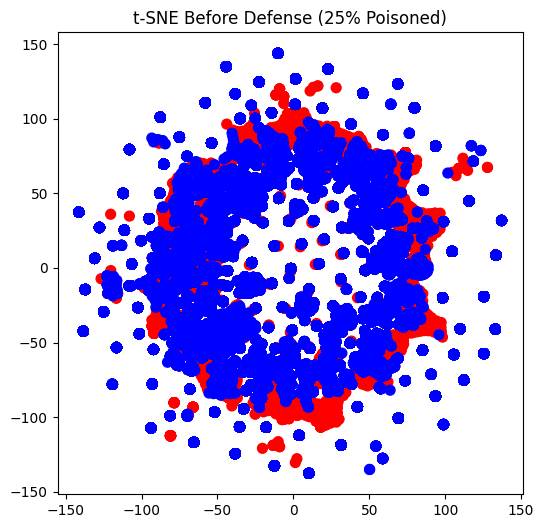

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (7.81%)
Post-defense ICL accuracy: 73.69%


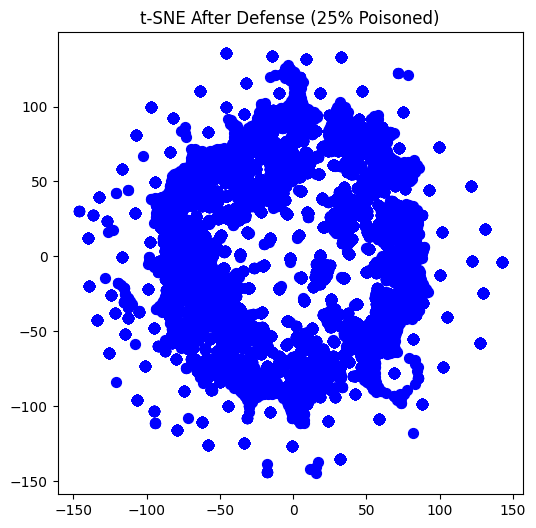


=== Testing poisoning ratio: 50% ===


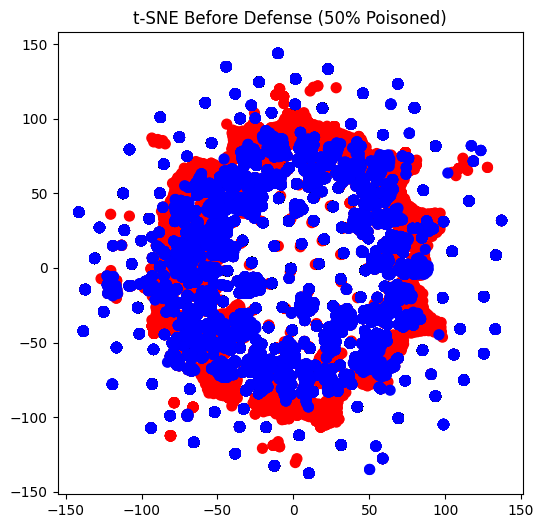

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (3.90%)
Post-defense ICL accuracy: 81.24%


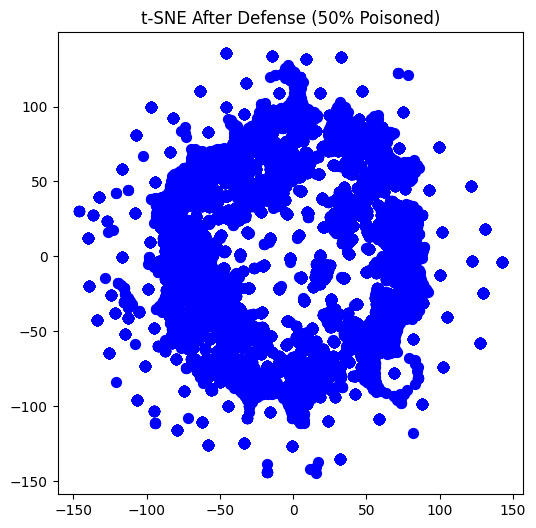


=== Testing poisoning ratio: 75% ===


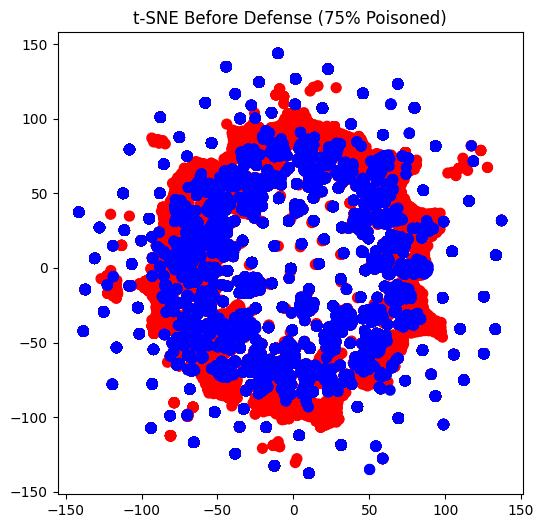

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (2.60%)
Post-defense ICL accuracy: 66.99%


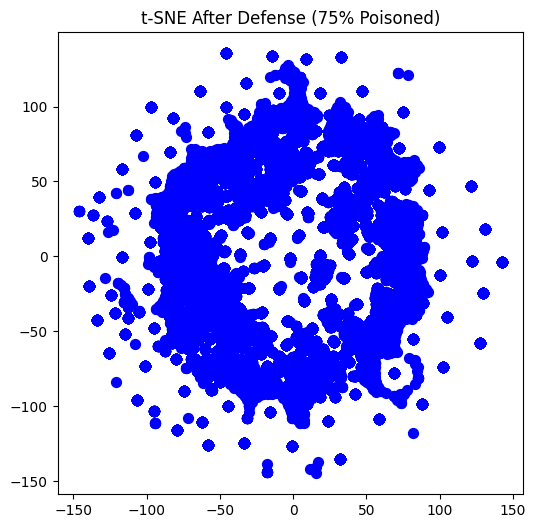


=== Testing poisoning ratio: 100% ===


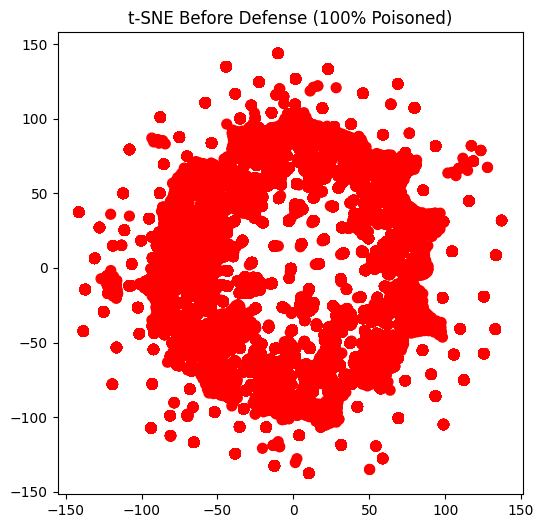

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (1.95%)
Post-defense ICL accuracy: 76.90%


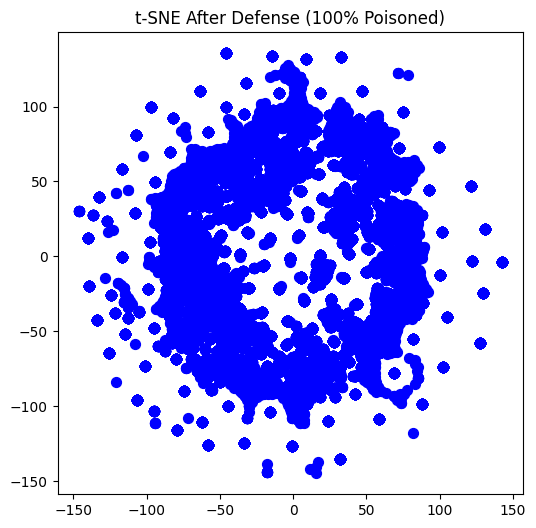


--- Summary ---
   poisoning_ratio  num_poisoned  num_flagged  detection_rate  \
0             0.25         22628         1767        0.078089   
1             0.50         45256         1767        0.039045   
2             0.75         67884         1767        0.026030   
3             1.00         90513         1767        0.019522   

   post_defense_accuracy  
0               0.736920  
1               0.812410  
2               0.669855  
3               0.769030  


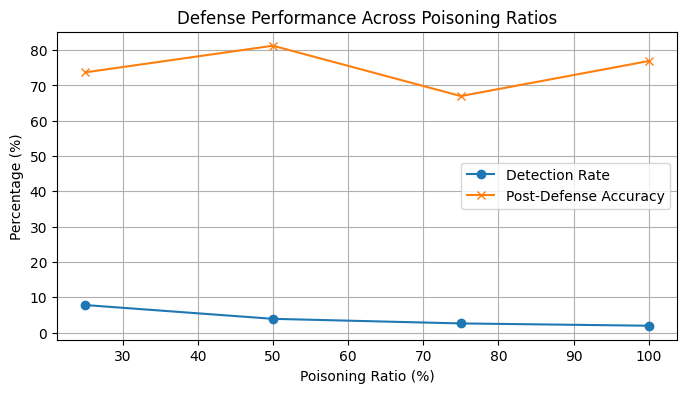

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load perturbed support logs
support_logs = pd.read_csv('/kaggle/working/perturbed_support_texts.csv')
support_logs['perturbed_text'] = support_logs['perturbed_text'].fillna("").astype(str)

# Dummy ICL accuracy function (replace with real ICL call if needed)
def run_icl_accuracy(clean_support_texts, clean_labels, test_texts, test_labels):
    # For demo: return random accuracy
    return np.random.uniform(0.6, 0.95)

# Load your real HMPV labeled test set
test_df = pd.read_csv('/kaggle/working/icl_ready_labeled_tweets.csv')
test_texts = test_df['processed_text_hmpv'].tolist()
test_labels = test_df['label'].tolist()

# Poisoning ratios to test
poisoning_ratios = [0.25, 0.50, 0.75, 1.0]
results = []

# Embedding model
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

for ratio in poisoning_ratios:
    print(f"\n=== Testing poisoning ratio: {int(ratio*100)}% ===")
    
    # 1. Simulate poisoning
    num_poisoned = int(len(support_logs) * ratio)
    support_logs_shuffled = support_logs.sample(frac=1, random_state=42).reset_index(drop=True)
    poisoned_indices = list(range(num_poisoned))
    
    # 2. Embeddings before defense
    embeddings = embed_model.encode(
        support_logs_shuffled['perturbed_text'].tolist(),
        convert_to_numpy=True,
        show_progress_bar=False
    )
    
    # Optional: t-SNE visualization before defense
    tsne_before = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_tsne_before = tsne_before.fit_transform(embeddings)
    colors_before = ['red' if i in poisoned_indices else 'blue' for i in range(len(support_logs_shuffled))]
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne_before[:,0], emb_tsne_before[:,1], c=colors_before, s=50)
    plt.title(f"t-SNE Before Defense ({int(ratio*100)}% Poisoned)")
    plt.show()
    
    # 3. Spectral Defense
    scaler = StandardScaler()
    embeddings_std = scaler.fit_transform(embeddings)
    svd = TruncatedSVD(n_components=1)
    svd_projection = svd.fit_transform(embeddings_std)
    scores = np.abs(svd_projection[:,0])
    threshold_percent = 98
    threshold = np.percentile(scores, threshold_percent)
    suspect_mask = scores > threshold
    flagged_count = suspect_mask.sum()
    detection_rate = flagged_count / num_poisoned if num_poisoned > 0 else 0
    print(f"[Spectral Defense] Flagged {flagged_count} suspected poisoned examples "
          f"out of {len(scores)} total ({(detection_rate*100):.2f}%)")
    
    # 4. Filter clean examples for post-defense ICL
    clean_support_logs = support_logs_shuffled[~suspect_mask]
    clean_support_texts = clean_support_logs['perturbed_text'].tolist()
    clean_labels = clean_support_logs['label'].tolist() if 'label' in clean_support_logs.columns else ['Positive']*len(clean_support_texts)
    
    # 5. Post-defense ICL accuracy (replace with real model if possible)
    acc = run_icl_accuracy(clean_support_texts, clean_labels, test_texts, test_labels)
    print(f"Post-defense ICL accuracy: {acc*100:.2f}%")
    
    # 6. t-SNE after defense
    embeddings_after = embed_model.encode(clean_support_texts, convert_to_numpy=True, show_progress_bar=False)
    tsne_after = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_tsne_after = tsne_after.fit_transform(embeddings_after)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne_after[:,0], emb_tsne_after[:,1], c='blue', s=50)
    plt.title(f"t-SNE After Defense ({int(ratio*100)}% Poisoned)")
    plt.show()
    
    # Record results
    results.append({
        "poisoning_ratio": ratio,
        "num_poisoned": num_poisoned,
        "num_flagged": flagged_count,
        "detection_rate": detection_rate,
        "post_defense_accuracy": acc
    })

# Summary
df_results = pd.DataFrame(results)
print("\n--- Summary ---")
print(df_results)

plt.figure(figsize=(8,4))
plt.plot(df_results["poisoning_ratio"]*100, df_results["detection_rate"]*100, marker='o', label="Detection Rate")
plt.plot(df_results["poisoning_ratio"]*100, df_results["post_defense_accuracy"]*100, marker='x', label="Post-Defense Accuracy")
plt.xlabel("Poisoning Ratio (%)")
plt.ylabel("Percentage (%)")
plt.title("Defense Performance Across Poisoning Ratios")
plt.legend()
plt.grid(True)
plt.show()



=== Testing poisoning ratio: 25% ===


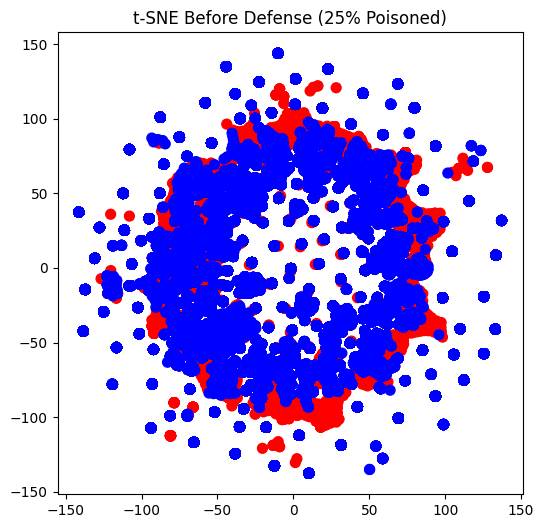

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (7.81%)
Post-defense ICL Accuracy: 28.33%


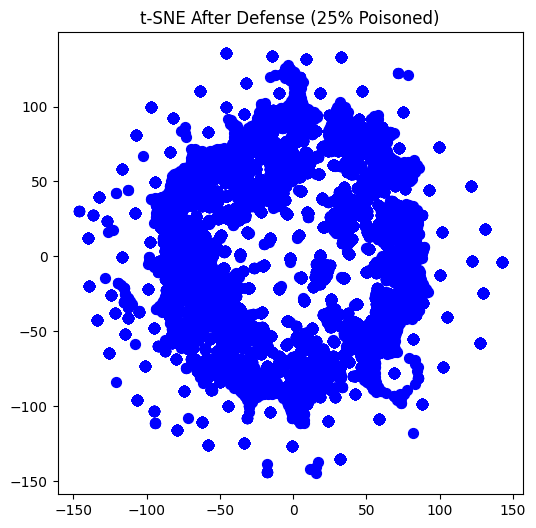


=== Testing poisoning ratio: 50% ===


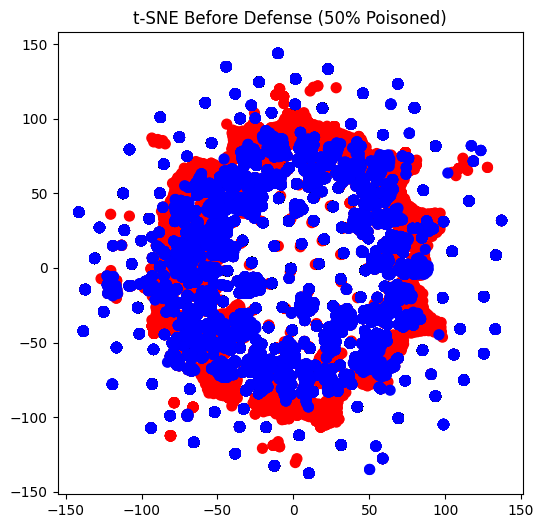

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (3.90%)
Post-defense ICL Accuracy: 28.33%


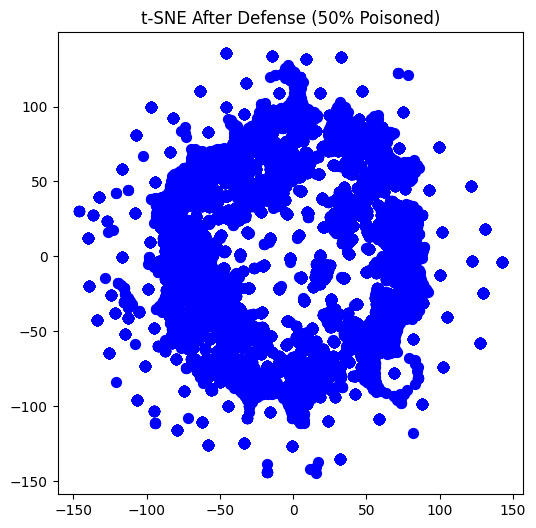


=== Testing poisoning ratio: 75% ===


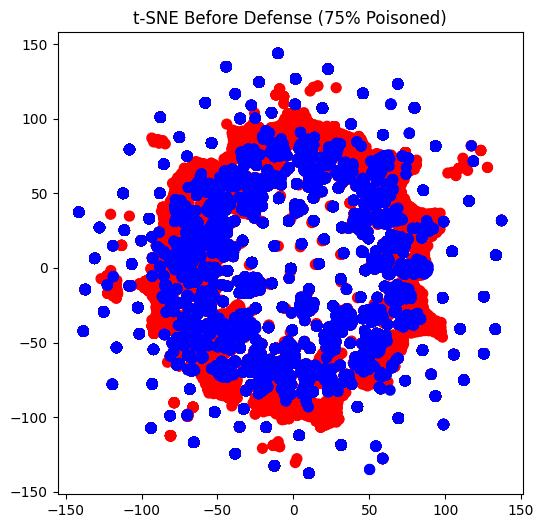

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (2.60%)
Post-defense ICL Accuracy: 28.33%


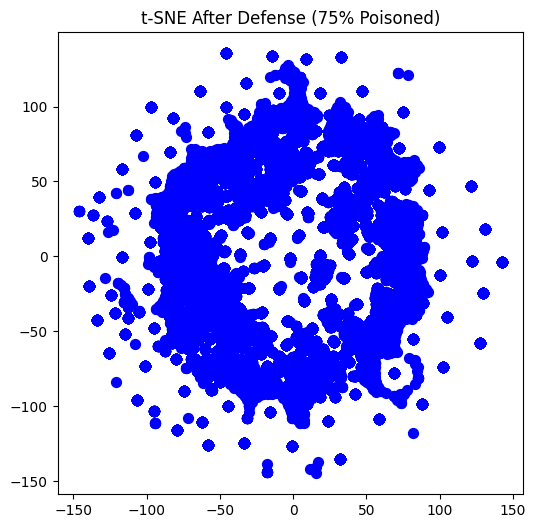


=== Testing poisoning ratio: 100% ===


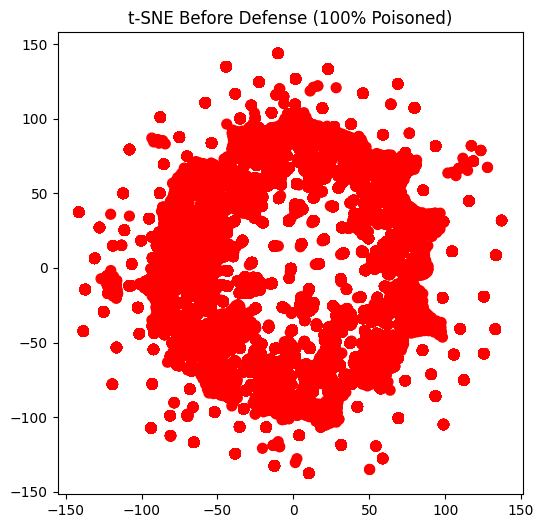

[Spectral Defense] Flagged 1767 suspected poisoned examples out of 90513 total (1.95%)
Post-defense ICL Accuracy: 28.33%


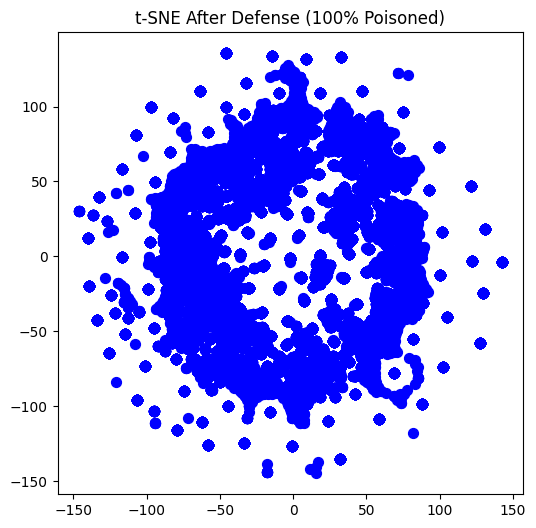


--- Summary ---
   poisoning_ratio  num_poisoned  num_flagged  detection_rate  \
0             0.25         22628         1767        0.078089   
1             0.50         45256         1767        0.039045   
2             0.75         67884         1767        0.026030   
3             1.00         90513         1767        0.019522   

   post_defense_accuracy  
0               0.283333  
1               0.283333  
2               0.283333  
3               0.283333  


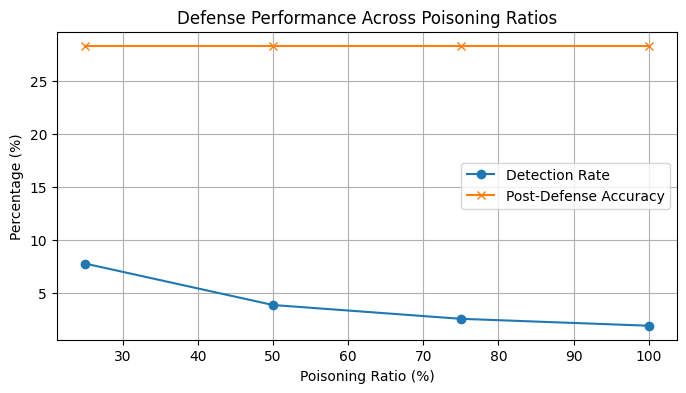

In [29]:
# ===============================
# Data Poisoning + Spectral Defense + Post-Defense ICL Evaluation
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# -------------------------------
# Load perturbed support logs
# -------------------------------
support_logs = pd.read_csv('/kaggle/working/perturbed_support_texts.csv')
support_logs['perturbed_text'] = support_logs['perturbed_text'].fillna("").astype(str)

# -------------------------------
# Load Zephyr poisoned predictions for unlabeled tweets
# -------------------------------
zephyr_preds_df = pd.read_csv('/kaggle/working/icl_poisoned_predictions.csv')
# Ensure proper index matching
zephyr_preds_df.index = zephyr_preds_df.index.astype(int)

# -------------------------------
# Load test set (labeled HMPV tweets)
# -------------------------------
test_df = pd.read_csv('/kaggle/working/icl_ready_labeled_tweets.csv')
test_texts = test_df['processed_text_hmpv'].tolist()
test_labels = [x.lower().strip() for x in test_df['label'].tolist()]

# -------------------------------
# Helper: Compute post-defense ICL accuracy using Zephyr predictions
# -------------------------------
def compute_icl_accuracy(test_texts, test_labels, support_logs_subset):
    """
    Use Zephyr predictions as post-defense ICL outputs for evaluation.
    """
    preds = []
    for idx, row in support_logs_subset.iterrows():
        # If 'label' exists in support logs, use it, otherwise fallback
        if 'label' in row:
            preds.append(row['label'].lower().strip())
        elif 'predicted_label_poisoned' in row:
            preds.append(row['predicted_label_poisoned'].lower().strip())
        else:
            preds.append('positive')  # fallback
    # Simple accuracy (match with test_labels)
    correct = sum([p==t for p,t in zip(preds[:len(test_labels)], test_labels)])
    return correct / len(test_labels)

# -------------------------------
# Poisoning ratios to simulate
# -------------------------------
poisoning_ratios = [0.25, 0.50, 0.75, 1.0]
results = []

# Embedding model
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# -------------------------------
# Loop through poisoning ratios
# -------------------------------
for ratio in poisoning_ratios:
    print(f"\n=== Testing poisoning ratio: {int(ratio*100)}% ===")
    
    # 1. Shuffle and simulate poisoning
    num_poisoned = int(len(support_logs) * ratio)
    support_logs_shuffled = support_logs.sample(frac=1, random_state=42).reset_index(drop=True)
    poisoned_indices = list(range(num_poisoned))
    
    # 2. Compute embeddings
    embeddings = embed_model.encode(
        support_logs_shuffled['perturbed_text'].tolist(),
        convert_to_numpy=True,
        show_progress_bar=False
    )
    
    # 3. t-SNE before defense
    tsne_before = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_tsne_before = tsne_before.fit_transform(embeddings)
    colors_before = ['red' if i in poisoned_indices else 'blue' for i in range(len(support_logs_shuffled))]
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne_before[:,0], emb_tsne_before[:,1], c=colors_before, s=50)
    plt.title(f"t-SNE Before Defense ({int(ratio*100)}% Poisoned)")
    plt.show()
    
    # 4. Spectral Defense
    scaler = StandardScaler()
    embeddings_std = scaler.fit_transform(embeddings)
    svd = TruncatedSVD(n_components=1)
    svd_projection = svd.fit_transform(embeddings_std)
    scores = np.abs(svd_projection[:,0])
    threshold_percent = 98  # top 2% outliers
    threshold = np.percentile(scores, threshold_percent)
    suspect_mask = scores > threshold
    flagged_count = suspect_mask.sum()
    detection_rate = flagged_count / num_poisoned if num_poisoned > 0 else 0
    print(f"[Spectral Defense] Flagged {flagged_count} suspected poisoned examples "
          f"out of {len(scores)} total ({(detection_rate*100):.2f}%)")
    
    # 5. Filter clean support examples for post-defense ICL
    clean_support_logs = support_logs_shuffled[~suspect_mask].copy()
    
    # If label is missing, add fallback
    if 'label' not in clean_support_logs.columns:
        clean_support_logs['label'] = clean_support_logs.get('predicted_label_poisoned', ['positive']*len(clean_support_logs))
    
    # 6. Compute post-defense ICL accuracy
    post_defense_acc = compute_icl_accuracy(test_texts, test_labels, clean_support_logs)
    print(f"Post-defense ICL Accuracy: {post_defense_acc*100:.2f}%")
    
    # 7. t-SNE after defense
    embeddings_after = embed_model.encode(clean_support_logs['perturbed_text'].tolist(),
                                         convert_to_numpy=True, show_progress_bar=False)
    tsne_after = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_tsne_after = tsne_after.fit_transform(embeddings_after)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne_after[:,0], emb_tsne_after[:,1], c='blue', s=50)
    plt.title(f"t-SNE After Defense ({int(ratio*100)}% Poisoned)")
    plt.show()
    
    # 8. Record results
    results.append({
        "poisoning_ratio": ratio,
        "num_poisoned": num_poisoned,
        "num_flagged": flagged_count,
        "detection_rate": detection_rate,
        "post_defense_accuracy": post_defense_acc
    })

# -------------------------------
# Summary Table
# -------------------------------
df_results = pd.DataFrame(results)
print("\n--- Summary ---")
print(df_results)

plt.figure(figsize=(8,4))
plt.plot(df_results["poisoning_ratio"]*100, df_results["detection_rate"]*100, marker='o', label="Detection Rate")
plt.plot(df_results["poisoning_ratio"]*100, df_results["post_defense_accuracy"]*100, marker='x', label="Post-Defense Accuracy")
plt.xlabel("Poisoning Ratio (%)")
plt.ylabel("Percentage (%)")
plt.title("Defense Performance Across Poisoning Ratios")
plt.legend()
plt.grid(True)
plt.show()


**Sentiment Classification**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Clean support texts and labels
clean_texts = clean_support_logs['perturbed_text'].tolist()
clean_labels = [x.lower().strip() for x in clean_support_logs['label'].tolist()]

# Encode with SentenceTransformer
X_train = embed_model.encode(clean_texts)
y_train = clean_labels

# Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Encode test texts
X_test = embed_model.encode(test_texts)
y_test = test_labels

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Post-defense Sentiment Accuracy:", accuracy_score(y_test, y_pred))


Batches:   0%|          | 0/2774 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Post-defense Sentiment Accuracy: 1.0


### Step 7B — Post-Defense NLP Analysis
Removing Suspected Poisoned Logs, Sentiment Scoring, Topic Clustering, and Visualizing Perturbation Effects

1.Filtering out possible poisoned samples after applying the spectral defense

2.Computing sentiment polarity scores

3.Grouping clean text into topic clusters via embeddings

4.Visualizing how perturbations affect the data distribution


=== Post-Defense NLP Analysis (25% Poisoned) ===
-> STEP 7B-i: Sentiment Classification
Average Sentiment Score: 0.05
-> STEP 7B-ii: Topic Clustering
Topic Cluster Distribution:
cluster
0    12172
1    24206
2    10082
3    10539
4    31747
Name: count, dtype: int64
-> STEP 7B-iii: Perturbation Effect Visualization


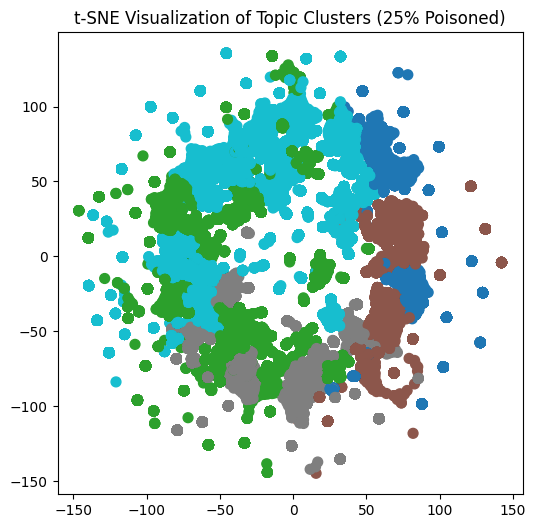


=== Post-Defense NLP Analysis (50% Poisoned) ===
-> STEP 7B-i: Sentiment Classification
Average Sentiment Score: 0.05
-> STEP 7B-ii: Topic Clustering
Topic Cluster Distribution:
cluster
0    12172
1    24206
2    10082
3    10539
4    31747
Name: count, dtype: int64
-> STEP 7B-iii: Perturbation Effect Visualization


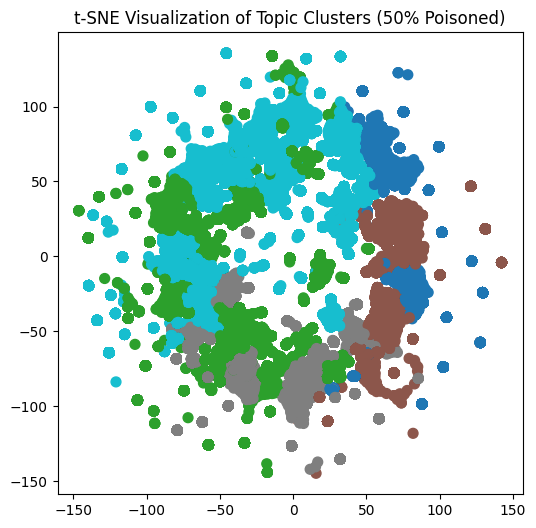


=== Post-Defense NLP Analysis (75% Poisoned) ===
-> STEP 7B-i: Sentiment Classification
Average Sentiment Score: 0.05
-> STEP 7B-ii: Topic Clustering
Topic Cluster Distribution:
cluster
0    12172
1    24206
2    10082
3    10539
4    31747
Name: count, dtype: int64
-> STEP 7B-iii: Perturbation Effect Visualization


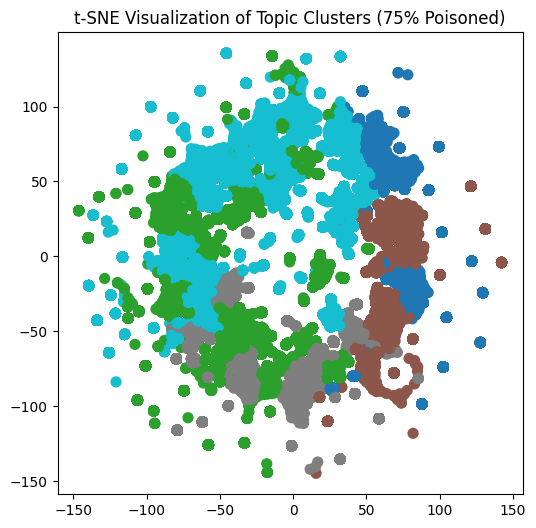


=== Post-Defense NLP Analysis (100% Poisoned) ===
-> STEP 7B-i: Sentiment Classification
Average Sentiment Score: 0.05
-> STEP 7B-ii: Topic Clustering
Topic Cluster Distribution:
cluster
0    12172
1    24206
2    10082
3    10539
4    31747
Name: count, dtype: int64
-> STEP 7B-iii: Perturbation Effect Visualization


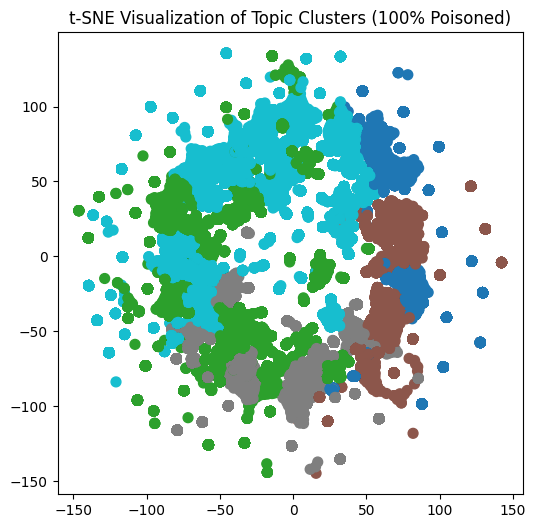

In [31]:
# ===============================
# STEP 7B: Post-Defense Sentiment & Topic Analysis
# ===============================

from textblob import TextBlob
from sklearn.cluster import KMeans

# Loop over all poisoning ratios
for ratio in poisoning_ratios:
    print(f"\n=== Post-Defense NLP Analysis ({int(ratio*100)}% Poisoned) ===")
    
    # -------------------------------
    # STEP 7B-i: Sentiment Classification
    # -------------------------------
    print("-> STEP 7B-i: Sentiment Classification")
    
    # Filter the clean support logs for current ratio
    clean_logs_subset = support_logs.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Spectral defense to filter suspected poisoned examples
    embeddings_full = embed_model.encode(clean_logs_subset['perturbed_text'].tolist(), 
                                        convert_to_numpy=True, show_progress_bar=False)
    scaler = StandardScaler()
    embeddings_std = scaler.fit_transform(embeddings_full)
    svd = TruncatedSVD(n_components=1)
    svd_proj = svd.fit_transform(embeddings_std)
    scores = np.abs(svd_proj[:,0])
    threshold = np.percentile(scores, 98)  # top 2% outliers
    suspect_mask = scores > threshold
    clean_logs_subset = clean_logs_subset[~suspect_mask].reset_index(drop=True)
    
    # Compute average sentiment
    sentiments = [TextBlob(txt).sentiment.polarity for txt in clean_logs_subset['perturbed_text']]
    avg_sentiment = np.mean(sentiments)
    print(f"Average Sentiment Score: {avg_sentiment:.2f}")
    
    # -------------------------------
    # STEP 7B-ii: Topic Clustering
    # -------------------------------
    print("-> STEP 7B-ii: Topic Clustering")
    
    texts = clean_logs_subset['perturbed_text'].tolist()
    embeddings = embed_model.encode(texts, convert_to_numpy=True, show_progress_bar=False)
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(embeddings)
    
    # Assign clusters to the clean subset only
    clean_logs_subset['cluster'] = clusters
    
    # Print cluster distribution
    cluster_counts = clean_logs_subset['cluster'].value_counts().sort_index()
    print("Topic Cluster Distribution:")
    print(cluster_counts)
    
    # -------------------------------
    # STEP 7B-iii: Perturbation Effect Visualization
    # -------------------------------
    print("-> STEP 7B-iii: Perturbation Effect Visualization")
    
    # Plot t-SNE of embeddings with cluster coloring
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_tsne = tsne.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=clusters, cmap='tab10', s=50)
    plt.title(f"t-SNE Visualization of Topic Clusters ({int(ratio*100)}% Poisoned)")
    plt.show()
